In [1]:
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')
back = Aer.get_backend('statevector_simulator')

Raw Image info: (256, 256, 4)
Raw Image datatype: uint8
Image shape (numpy array): (256, 256)


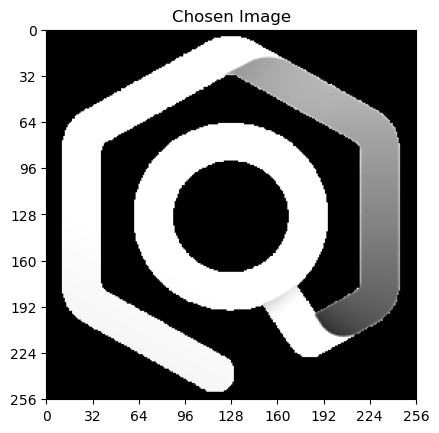

In [3]:
from PIL import Image
style.use('default')

image_size = 256      # Original image-width
image_crop_size = 32   # Width of each part of image for processing


# Load the image from filesystem
image_raw = np.array(Image.open('./mozilla_test.png'))
print('Raw Image info:', image_raw.shape)
print('Raw Image datatype:', image_raw.dtype)


# Convert the RBG component of the image to B&W image, as a numpy (uint8) array
image = []
for i in range(image_size):
    image.append([])
    for j in range(image_size):
        image[i].append(image_raw[i][j][0] / 255)
            
image = np.array(image)
print('Image shape (numpy array):', image.shape)

imgmat = []
for k in range(int(image_size / image_crop_size)):
    imgmat.append([])
    for l in range(int(image_size / image_crop_size) ):
        lx = int(k * image_crop_size)
        ux = int((k + 1) * image_crop_size)
        ly = int(l * image_crop_size)
        uy = int((l + 1) * image_crop_size)
        imgmat[k].append(image[lx:ux, ly:uy])

# Display the image
plt.title('Chosen Image')
plt.xticks(range(0, image.shape[0]+1, 32))
plt.yticks(range(0, image.shape[1]+1, 32))
plt.imshow(image, extent=[0, image.shape[0], image.shape[1], 0], cmap='gray')
plt.show()

In [4]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    if rms == 0: # exception for all 0's (i.e. a blank image) to prevent divide by 0 errors
        return np.array(img_data)
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

In [5]:
# Initialize some global variable for number of qubits
data_qb = 10
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

In [6]:
# Create the circuit for horizontal scan

horiz_scan = []
vert_scan = []
# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (amp > 1e-3 or amp < -1e-3)

for x in range(int(image_size / image_crop_size)):
    horiz_scan.append([])
    vert_scan.append([])
    for y in range(int(image_size / image_crop_size)):
        
        # Get the amplitude encoded pixel values
        # Horizontal: Original image
        image_norm_h = amplitude_encode(imgmat[x][y])

        # Vertical: Transpose of Original image
        image_norm_v = amplitude_encode(imgmat[x][y].T)
        
        if(image_norm_h.sum() != 0 and image_norm_v.sum() != 0):
            qc_h = QuantumCircuit(total_qb)
            qc_h.initialize(image_norm_h, range(1, total_qb))
            qc_h.h(0)
            qc_h.unitary(D2n_1, range(total_qb))
            qc_h.h(0)
            # display(qc_h.draw('mpl', fold=-1))

            # Create the circuit for vertical scan
            qc_v = QuantumCircuit(total_qb)
            qc_v.initialize(image_norm_v, range(1, total_qb))
            qc_v.h(0)
            qc_v.unitary(D2n_1, range(total_qb))
            qc_v.h(0)
            # display(qc_v.draw('mpl', fold=-1))

            # Combine both circuits into a single list
            circ_list = [qc_h, qc_v]

            # Simulating the cirucits
            job2 = execute(circ_list, backend=back)
            results = job2.result()

            sv_h = results.get_statevector(qc_h)
            sv_v = results.get_statevector(qc_v)


            # Classical postprocessing for plotting the output

            # Selecting odd states from the raw statevector and
            # reshaping column vector of size 64 to an 8x8 matrix
            edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(image_crop_size, image_crop_size)
            edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(image_crop_size, image_crop_size).T
            
        else:
            edge_scan_h = imgmat[x][y]
            edge_scan_v = imgmat[x][y].T
        horiz_scan[x].append(edge_scan_h)
        vert_scan[x].append(edge_scan_v)

In [7]:
edge_scan_sim = []
# horiz_scan | vert_scan
# for hrow in range(int(image_size / image_crop_size) - 1):
#     edge_scan_sim.append([])
#     for vrow in range(int(image_size / image_crop_size) - 1):     
for i, (hrow, vrow) in enumerate(zip(horiz_scan, vert_scan)):
    edge_scan_sim.append([])
    for h, v in zip(hrow, vrow):
        edge_scan_sim[i].append(h.astype(int) | v.astype(int))
            

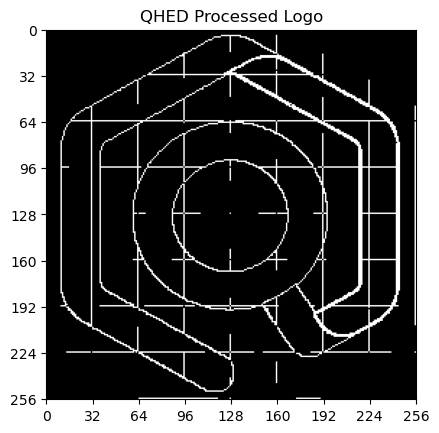

In [8]:
# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(0, img.shape[0]+1, 32))
    plt.yticks(range(0, img.shape[1]+1, 32))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='gray')
    plt.show()
    
# recombine our array of chunks into a single image
edge_rows = [np.hstack(row) for row in edge_scan_sim]
edges = np.vstack(edge_rows)

plot_image(edges, 'QHED Processed Logo')

In [9]:
data = Image.fromarray(edges)
plt.imsave('mozilla_test_edges.jpeg', data)